In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import networkx as nx
import ndex2

from scipy.stats import ttest_ind, mannwhitneyu
from statsmodels.sandbox.stats.multicomp import multipletests

from tqdm.auto import tqdm

import src

%matplotlib inline

# Load Data

## BioPlex

In [2]:
bioplex = src.io.load_cx_network('../Data/BioPlex2.0.cx',
                                 network_mode='undirected',
                                 print_stats=True)

Network contains 10961 nodes and 56553 edges


## RNA-seq caco-2

In [3]:
rnaseq = pd.read_csv('../Data/Transcriptomics-Caco2_polyA_fpkm.tsv', sep='\t')

In [4]:
rnaseq['gene'] = rnaseq['gene_id||gene_name'].apply(lambda x: x.split('||')[1])
rnaseq.set_index('gene', inplace=True)

In [5]:
rnaseq.head()

,gene_id||gene_name,length,Caco2_polyA-S1-4h-A,Caco2_polyA-S1-4h-B,Caco2_polyA-S1-12h-A,Caco2_polyA-S1-12h-B,Caco2_polyA-S1-24h-A,Caco2_polyA-S1-24h-B,Caco2_polyA-S2-4h-A,Caco2_polyA-S2-4h-B,Caco2_polyA-S2-12h-A,Caco2_polyA-S2-12h-B,Caco2_polyA-S2-24h-A,Caco2_polyA-S2-24h-B,Caco2_polyA-mock-4h-A,Caco2_polyA-mock-4h-B,Caco2_polyA-mock-24h-A,Caco2_polyA-mock-24h-B,Caco2_polyA-untr-4h-A,Caco2_polyA-untr-4h-B
gene,,,,,,,,,,,,,,,,,,,,
ETV5-AS1,ENSG00000234197.1||ETV5-AS1,560,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
LINC01299,ENSG00000254081.1||LINC01299,2634,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.036,0.000,0.000,0.115,0.000,0.000,0.000,0.000,0.000,0.000,0.042
MLLT3,ENSG00000171843.16||MLLT3,8100,2.984,3.047,3.390,3.193,4.044,3.989,2.847,2.893,2.865,2.823,3.829,3.711,3.315,3.052,3.130,3.220,3.622,3.931
SCGB3A2,ENSG00000164265.9||SCGB3A2,1075,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.052,0.000,0.000
SEPT10P1,ENSG00000253541.1||SEPT10P1,1162,0.847,1.082,1.796,1.252,0.000,1.272,1.475,1.551,1.106,1.265,1.043,0.900,0.999,1.002,0.965,1.202,1.207,0.864


In [6]:
rnaseq.shape

(45057, 20)

## Proteomics caco-2

In [7]:
prot = pd.read_excel('../Data/Proteomics-Nature.xlsx')

In [8]:
prot.head()

,Accession,Species Names01,Gene Symbol01,Control 2h,Control 2h_2,Control 2h_3,Control 6h_1,Control 6h_2,Control 6h_3,Control 10h_1,...,Virus 24h_2,Virus 24h_3,Ratio 2h,Ratio 6h,Ratio 10h,Ratio 24h,P value 2h,P value 6h,P value 10h,P value 24h
0,P02771,Homo sapiens OX=9606,AFP,981.258045,1183.175939,1440.326216,1205.249514,1338.177985,1286.491071,925.301366,...,49.176430,74.536415,-0.236188,-0.327616,-0.136694,-4.489913,0.490451,0.061289,0.599956,0.000180
1,P07148,Homo sapiens OX=9606,FABP1,1305.009230,1280.049817,1210.800481,1154.277967,1100.749505,923.312640,773.390082,...,90.028324,0.000000,-0.177061,-0.347504,-0.140953,-3.286986,0.037763,0.058714,0.792982,0.000182
2,P09327,Homo sapiens OX=9606,VIL1,839.773511,1031.083693,972.479005,860.300797,988.012894,962.336146,753.439585,...,89.112956,73.822910,-0.150779,-0.279991,-0.645486,-3.444579,0.398441,0.052874,0.016658,0.000165
3,P05783,Homo sapiens OX=9606,KRT18,604.780284,727.433897,784.113305,1264.895045,1318.047640,1405.874444,1297.249528,...,377.705066,665.080284,-0.096411,-0.017061,-0.157926,-0.229857,0.603719,0.884344,0.328675,0.583561
4,Q9P2E9,Homo sapiens OX=9606,NaN,686.321978,636.582512,668.096982,828.087137,794.704113,671.987378,631.514053,...,103.232566,135.262875,-0.135448,-0.163304,-0.440900,-2.140370,0.092775,0.258608,0.032700,0.000020


## Uniprot Mapper

In [9]:
uniprot = pd.read_csv('../Data/Uniprot-Map.tsv', sep='\t')

In [10]:
mapper = dict(zip(uniprot['From'].values.tolist(), uniprot['To'].values.tolist()))

In [11]:
def map_prot(name, mapper):
    if name in list(mapper.keys()):
        return mapper[name]
    else:
        return name

In [12]:
for idx in prot.loc[prot['Gene Symbol01'].isna()]['Accession'].index:
    try:
        prot.at[idx, 'Gene Symbol01'] = map_prot(prot.loc[idx, 'Accession'], mapper)
    except:
        pass
    print(prot.at[idx, 'Gene Symbol01'])

RRBP1
Q9N2J8
PRMT1
SOD2
PCK2
Spike
PCM1
P0DTC8
AUP1
P0DTD2
PON2
HSPBP1
N
Orf7a
NRDC
PNN
EPPK1
AGRN
SEC16A
SRGAP2
ATP2B1
MTX1
GRIPAP1
AKAP9


# DE analysis

In [13]:
prot.columns

Index(['Accession', 'Species Names01', 'Gene Symbol01', 'Control 2h',
       'Control 2h_2', 'Control 2h_3', 'Control 6h_1', 'Control 6h_2',
       'Control 6h_3', 'Control 10h_1 ', 'Control 10h_2', 'Control 10h_3',
       'Control 24h_1', 'Control 24h_2', 'Control 24h_3', 'Virus 2h_1',
       'Virus 2h_2', 'Virus 2h_3', 'Virus 6h_1', 'Virus 6h_2', 'Virus 6h_3',
       'Virus 10h_1', 'Virus 10h_2', 'Virus 10h_3', 'Virus 24h_1',
       'Virus 24h_2', 'Virus 24h_3', 'Ratio 2h', 'Ratio 6h', 'Ratio 10h ',
       'Ratio 24h', 'P value 2h', 'P value 6h', 'P value 10h', 'P value 24h'],
      dtype='object')

### Proteomics

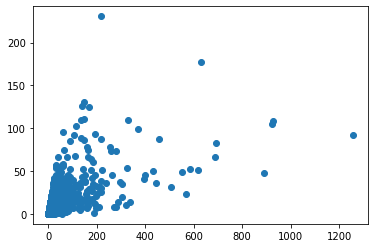

In [14]:
plt.scatter(prot[['Control 24h_1', 'Control 24h_2', 'Control 24h_3']].mean(axis=1).values,
            np.sqrt(prot[['Control 24h_1', 'Control 24h_2', 'Control 24h_3']].var(axis=1).values))

In [15]:
control_col = ['Control 24h_1', 'Control 24h_2', 'Control 24h_3']
virus_col = ['Virus 24h_1', 'Virus 24h_2', 'Virus 24h_3']

In [16]:
data = prot[['Gene Symbol01'] + control_col + virus_col]

In [17]:
data.columns = ['Gene'] + control_col + virus_col
data.set_index('Gene', inplace=True)

In [18]:
def test(x,y):
    try:
        return ttest_ind(x, y)[1]
    except:
        return 1.0


data['Pval'] = data.apply(lambda row: test(row[control_col].dropna().values,
                                           row[virus_col].dropna().values), axis=1)

data['Pval'] = data['Pval'].fillna(1.0)

/Users/earmingol/opt/anaconda3/envs/networks/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/Users/earmingol/opt/anaconda3/envs/networks/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/earmingol/opt/anaconda3/envs/networks/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/Users/earmingol/opt/anaconda3/envs/networks/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

In [19]:
data['FDR'] = multipletests(data['Pval'].values, alpha=0.1, method='fdr_bh')[1]

/Users/earmingol/opt/anaconda3/envs/networks/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [20]:
data.loc[data['FDR'] < 0.1]

,Control 24h_1,Control 24h_2,Control 24h_3,Virus 24h_1,Virus 24h_2,Virus 24h_3,Pval,FDR
Gene,,,,,,,,
AFP,844.290854,886.532318,1048.975414,0.000000,49.176430,74.536415,0.000180,0.015966
FABP1,938.899082,886.075222,842.460815,183.254575,90.028324,0.000000,0.000182,0.015966
VIL1,802.704246,1003.939755,957.793517,90.977274,89.112956,73.822910,0.000165,0.015966
RRBP1,594.334880,561.067395,550.510551,148.442462,103.232566,135.262875,0.000020,0.006124
ANXA4,1346.827328,1261.916261,1161.811392,164.152240,182.159981,328.391077,0.000158,0.015966
...,...,...,...,...,...,...,...,...
KRT17,0.000000,0.000000,0.000000,301.512643,342.050333,425.077478,0.000609,0.031850
CCDC47,38.171732,17.010446,0.000000,136.833140,113.657475,107.463249,0.002074,0.072174
ATP5A1,17.235176,0.000000,3.024276,59.778030,64.247268,62.616166,0.000533,0.030019


In [21]:
def fold_change(x, y, fdr, min_val=900, alpha=0.05):
    if fdr >= alpha:
        return 1.0
    else:
        if x == np.nan:
            x = 0.
        if y == np.nan:
            y = 0.

        if y != 0:
            return x / y
        else:
            if x != 0:
                return np.min([min_val, x])
            else:
                return 1.0

In [22]:
data['FC'] = data.apply(lambda row: fold_change(np.nanmean(row[virus_col]),
                                                np.nanmean(row[control_col]),
                                                row['FDR'],
                                                alpha=0.1
                                               ), axis=1)

/Users/earmingol/opt/anaconda3/envs/networks/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [23]:
data['FC'] = data['FC'].fillna(1.0)

/Users/earmingol/opt/anaconda3/envs/networks/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [24]:
np.median(data['FC'].values)

1.0

In [25]:
len(data)

2715

In [26]:
data.loc[data['FC'] != 1.0]['FC'].sort_values(ascending=False).index

Index(['ENO1', 'KRT17', 'CEBPZ', 'AKAP12', 'GDI1', 'PRDX6', 'ATP5A1', 'YARS',
       'CCDC47', 'PPIC', 'COX5B', 'C16orf62', 'MYADM', 'PCYOX1',
       'APOA1BP; NAXE', 'CHMP1B', 'CAT', 'GNPDA1', 'VPS26A', 'MDH2', 'LGALS3',
       'MYO1D', 'CHMP2B', 'DSP', 'RPL29', 'S100A10', 'ACAA2', 'UBL5',
       'ATP6V1G1', 'SEC61B', 'TSPAN8', 'RRBP1', 'CTSA', 'RPL35', 'NDUFA4',
       'IDH1', 'CTSB', 'CTSD', 'JUP', 'H3F3A; H3F3AP4; H3F3B', 'ANXA4',
       'HIST1H1E', 'HIST1H1C', 'H1F0', 'ASAH1', 'DPP4', 'SLC9A3R1', 'MUC13',
       'TMBIM6', 'IGHV3-21', 'CDH17', 'PITRM1', 'FABP1', 'NDUFB3', 'SEPT9',
       'VIL1', 'SYAP1', 'CIRBP', 'SERPINA1', 'CYP51A1', 'ALDH1A1', 'APOA2',
       'TECR', 'OAT', 'AFP', 'DHCR7', 'EPCAM', 'TTR', 'APOE', 'TMCO1',
       'ABHD10', 'NELFCD; TH1L', 'UBE2C', 'RPE', 'OSGEP', 'RRP9', 'NOL7',
       'EMC1', 'MRPL14', 'KPNA2', 'VPS35', 'UBE2Z', 'CHERP', 'EIF1', 'TSPYL1',
       'CTNNA1', 'APOA1', 'CUL3', 'UQCR10', 'DYNLRB1', 'PSMD4', 'SLC39A14',
       'NDUFAF7', 'SCO2', 'PPL',

In [27]:
personalization = dict()

for idx, row in data.iterrows():
    for i in idx.split('; '):
        personalization[i] = row['FC']

In [28]:
len(personalization)

2844

In [29]:
src.io.export_variable_with_pickle(personalization, '../Outputs/Proteomics-Personalization.pkl')

../Outputs/Proteomics-Personalization.pkl was correctly saved.


In [30]:
perso = src.io.load_variable_with_pickle('../Outputs/Proteomics-Personalization.pkl')

In [31]:
len(perso)

2844

## Transcriptomics

In [32]:
rnaseq.columns

Index(['gene_id||gene_name', 'length', 'Caco2_polyA-S1-4h-A',
       'Caco2_polyA-S1-4h-B', 'Caco2_polyA-S1-12h-A', 'Caco2_polyA-S1-12h-B',
       'Caco2_polyA-S1-24h-A', 'Caco2_polyA-S1-24h-B', 'Caco2_polyA-S2-4h-A',
       'Caco2_polyA-S2-4h-B', 'Caco2_polyA-S2-12h-A', 'Caco2_polyA-S2-12h-B',
       'Caco2_polyA-S2-24h-A', 'Caco2_polyA-S2-24h-B', 'Caco2_polyA-mock-4h-A',
       'Caco2_polyA-mock-4h-B', 'Caco2_polyA-mock-24h-A',
       'Caco2_polyA-mock-24h-B', 'Caco2_polyA-untr-4h-A',
       'Caco2_polyA-untr-4h-B'],
      dtype='object')

In [33]:
rna_control = ['Caco2_polyA-untr-4h-A', 'Caco2_polyA-untr-4h-B']

In [34]:
rna_virus = ['Caco2_polyA-S1-24h-A', 'Caco2_polyA-S1-24h-B', 'Caco2_polyA-S2-24h-A', 'Caco2_polyA-S2-24h-B',]

In [35]:
rna_in_bioplex = []
for idx in rnaseq.index:
    if idx in bioplex.nodes:
        rna_in_bioplex.append(idx)

In [36]:
len(rna_in_bioplex)

9934

In [37]:
rna_data = rnaseq[rna_control + rna_virus]

In [38]:
rna_data['Pval'] = rna_data.apply(lambda row: test(np.log2(row[rna_control].dropna().values + 1.),
                                                   np.log2(row[rna_virus].dropna().values + 1.)), axis=1)

rna_data['Pval'] = rna_data['Pval'].fillna(1.0)

/Users/earmingol/opt/anaconda3/envs/networks/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/earmingol/opt/anaconda3/envs/networks/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [39]:
rna_data['FDR'] = multipletests(rna_data['Pval'].values, alpha=0.1, method='fdr_bh')[1]

/Users/earmingol/opt/anaconda3/envs/networks/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [40]:
rna_data['FC'] = rna_data.apply(lambda row: fold_change(np.nanmean(row[rna_virus]),
                                                        np.nanmean(row[rna_control]),
                                                        row['FDR'],
                                                        alpha=0.1
                                                        ), axis=1)

/Users/earmingol/opt/anaconda3/envs/networks/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [41]:
rna_data['FC'].sort_values(ascending=False)

gene
KRT6A          133.958824
ALLC            32.782609
MAP3K20-AS1     29.297297
IL1RAPL1        17.966667
HSPD1P10        17.515152
                  ...    
IGBP1-AS2        0.000000
AC007435.1       0.000000
MIR4730          0.000000
PSCA             0.000000
RF00017          0.000000
Name: FC, Length: 45057, dtype: float64

In [42]:
rna_data.loc[rna_data['FC'] > 1.0]['FC'].sort_values(ascending=False).head(20)

gene
KRT6A          133.958824
ALLC            32.782609
MAP3K20-AS1     29.297297
IL1RAPL1        17.966667
HSPD1P10        17.515152
RPL3L           16.738095
AF287957.1      15.500000
HIST2H2BF       15.185714
LINC00431       13.459184
IRGM            12.976190
TNS4            11.949561
SERPINE1        11.690308
ELK3            10.389535
HIST1H2AL        9.103093
MYH16            8.760116
PLA2G4D          8.420455
TRPM2            8.233333
ETV7             8.191244
HIST1H4H         8.009170
HIST1H2BG        7.613946
Name: FC, dtype: float64

In [43]:
rna_personalization = dict()

for idx in rna_data.index:
    if idx in bioplex.nodes:
        result = rna_data.loc[idx, 'FC']
        if isinstance(result, np.float64):
            rna_personalization[idx] = result
        else:
            rna_personalization[idx] = result.values.flatten()[0]

In [44]:
len(rna_personalization)

9922

In [45]:
src.io.export_variable_with_pickle(rna_personalization, '../Outputs/Transcriptomics-Personalization.pkl')

../Outputs/Transcriptomics-Personalization.pkl was correctly saved.
